In [1]:
from cobolt.utils import SingleData, MultiomicDataset
from cobolt.model import Cobolt
import os
import gc
import numpy as np
import pandas as pd
import scipy.sparse as sps
import scanpy as sc
import h5py
import scipy.io as sio
import warnings
from muon import atac as ac
import seaborn as sns

from os.path import join
import matplotlib.pyplot as plt

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def wrap_warn_comp_plot(ads, basis, colors, figw=5, figh=4, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, color in enumerate(colors):
            _, axes = plt.subplots(1, len(ads), figsize=(figw*len(ads), figh))
            for j, ad in enumerate(ads):
                sc.pl.embedding(ad, basis=basis, color=color, ax=axes[j], show=False, **kwargs)
            plt.show()
            
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def load_h5(path):
    with h5py.File(path, 'r') as f:
        print(f['matrix'].keys())
        print(f['matrix']['features'].keys())

        barcodes = [_.decode('utf-8') for _ in f['matrix']['barcodes'][:]]
        data = f['matrix']['data'][:]
        indices = f['matrix']['indices'][:]
        indptr = f['matrix']['indptr'][:]
        shape = f['matrix']['shape'][:]

        feature_type = [_.decode('utf-8') for _ in f['matrix']['features']['feature_type'][:]]
        feature_id   = [_.decode('utf-8') for _ in f['matrix']['features']['id'][:]]
        feature_name = [_.decode('utf-8') for _ in f['matrix']['features']['name'][:]]
        feature_interval = [_.decode('utf-8') for _ in f['matrix']['features']['interval'][:]]


        X = sps.csc_matrix(
            (data, indices, indptr), 
            shape = shape
        ).tocsc().astype(np.float32).T.toarray()

        adata = sc.AnnData(X)
        adata.obs_names = barcodes
        adata.var_names = feature_id
        adata.var['type'] = feature_type
        adata.var['name'] = feature_name
        adata.var['interval'] = feature_interval
    return adata

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

def eval_ads(ads, ref_key, src_key):
    aris = []
    for ad in ads:
        aris.append(adjusted_rand_score(ad.obs[src_key], ad.obs[ref_key]))
    return aris

from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2


In [8]:
def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v
    
def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def set_spatial(ad):
    ad.obsm['spatial'] = ad.obs[['array_row', 'array_col']].values
    ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]
    ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
    return ad

def reorder(ad1, ad2):
    shared_barcodes = ad1.obs_names.intersection(ad2.obs_names)
    ad1 = ad1[shared_barcodes].copy()
    ad2 = ad2[shared_barcodes].copy()
    return ad1, ad2

def load_peak_expr(_dir):
    data = sio.mmread(join(_dir, 'data.mtx'))
    cname = pd.read_csv(join(_dir, 'barcode.csv'), index_col=0)['x'].to_list()
    feat = pd.read_csv(join(_dir, 'feat.csv'), index_col=0)['x'].to_list()
    ad = sc.AnnData(sps.csr_matrix(data.T))
    ad.obs_names = cname
    ad.var_names = feat
    return ad

def add_name_prefix(list, prefix):
    new_list = [f'{prefix}-{x}' for x in list]
    return new_list

In [4]:
# rna+H3K27me3
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+H3K27me3'
df_mult_rna = pd.read_csv(join(data_dir, 'rna+H3K27me3/GSM6753044_MouseBrain_20um_100barcodes_H3K27me3_matrix.tsv'), sep='\t')
df_mult_rna_spatial = pd.read_csv(join(data_dir, 'rna+H3K27me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_rna = sc.AnnData(df_mult_rna.T, obsm={'spatial': df_mult_rna_spatial.loc[df_mult_rna.columns, [2, 3]].values})
ad_mult_rna.layers['counts'] = ad_mult_rna.X.copy()

ad_mult_atac = load_peak_expr(join(data_dir, 'rna+H3K27me3/peak_data'))
df_mult_atac_spatial = pd.read_csv(join(data_dir, 'rna+H3K27me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_atac.obsm['spatial'] = df_mult_atac_spatial.loc[ad_mult_atac.obs_names, [2, 3]].values
ad_mult_atac.layers['counts'] = ad_mult_atac.X.copy()

ad_mult_rna, ad_mult_atac = reorder(ad_mult_rna, ad_mult_atac)

# rna+H3K4me3
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+H3K4me3'
df_mult_rna2 = pd.read_csv(join(data_dir, 'rna+H3K4me3/GSM6753046_MouseBrain_20um_100barcodes_H3K4me3_matrix.tsv'), sep='\t')
df_mult_rna_spatial2 =pd.read_csv(join(data_dir, 'rna+H3K4me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_rna2 = sc.AnnData(df_mult_rna2.T, obsm={'spatial': df_mult_rna_spatial2.loc[df_mult_rna2.columns, [2, 3]].values})
ad_mult_rna2.layers['counts'] = ad_mult_rna2.X.copy()

ad_mult_atac2 = load_peak_expr(join(data_dir, 'rna+H3K4me3/peak_data'))
df_mult_atac_spatial2 = pd.read_csv(join(data_dir, 'rna+H3K4me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_atac2.obsm['spatial'] = df_mult_atac_spatial2.loc[ad_mult_atac2.obs_names, [2, 3]].values
ad_mult_atac2.layers['counts'] = ad_mult_atac2.X.copy()

ad_mult_rna2, ad_mult_atac2 = reorder(ad_mult_rna2, ad_mult_atac2)

# rna+H3K27ac
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+H3K27ac/'
df_mult_rna3 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753045_MouseBrain_20um_100barcodes_H3K27ac_matrix.tsv'), sep='\t')
df_mult_rna_spatial3 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753045_spatial/tissue_positions_list.csv'), index_col=0, header=None)
ad_mult_rna3 = sc.AnnData(df_mult_rna3.T, obsm={'spatial': df_mult_rna_spatial3.loc[df_mult_rna3.columns, [2, 3]].values})
ad_mult_rna3.layers['counts'] = ad_mult_rna3.X.copy()

ad_mult_atac3 = load_peak_expr(join(data_dir, 'rna+atac/peak_data_3slices/GSM6753045_peak_data'))
df_mult_atac_spatial3 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753045_spatial/tissue_positions_list.csv'), index_col=0, header=None)
ad_mult_atac3.obsm['spatial'] = df_mult_atac_spatial3.loc[ad_mult_atac3.obs_names, [2, 3]].values
ad_mult_atac3.layers['counts'] = ad_mult_atac3.X.copy()

ad_mult_rna3, ad_mult_atac3 = reorder(ad_mult_rna3, ad_mult_atac3)

# rna+atac
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+atac/'
df_mult_rna4 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753043_MouseBrain_20um_100barcodes_ATAC_matrix.tsv'), sep='\t')
df_mult_rna_spatial4 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753043_MouseBrain_20um_100barcodes_ATAC_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_rna4 = sc.AnnData(df_mult_rna4.T, obsm={'spatial': df_mult_rna_spatial4.loc[df_mult_rna4.columns, [2, 3]].values})
ad_mult_rna4.layers['counts'] = ad_mult_rna4.X.copy()

ad_mult_atac4 = load_peak_expr(join(data_dir, 'rna+atac/For_Imputation_Task/GSM6758285_peak_data'))
df_mult_atac_spatial4 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753043_MouseBrain_20um_100barcodes_ATAC_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_atac4.obsm['spatial'] = df_mult_atac_spatial4.loc[ad_mult_atac4.obs_names, [2, 3]].values
ad_mult_atac4.layers['counts'] = ad_mult_atac4.X.copy()

ad_mult_rna4, ad_mult_atac4 = reorder(ad_mult_rna4, ad_mult_atac4)

In [5]:
def flip_coords(ads):
    for ad in ads:
        ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
        
flip_coords([ad_mult_rna, ad_mult_rna2, ad_mult_rna3, ad_mult_rna4])

In [6]:
shared_gene = ad_mult_rna.var_names
for ad in [ad_mult_rna2, ad_mult_rna3, ad_mult_rna4]:
    shared_gene = np.intersect1d(ad.var_names, shared_gene)
for ad in [ad_mult_rna, ad_mult_rna2, ad_mult_rna3, ad_mult_rna4]:
    ad = ad[:, shared_gene].copy()

In [9]:
ad_mult_rna.obs_names = ad_mult_atac.obs_names = add_name_prefix(ad_mult_rna.obs_names, 'rna+H3K27me3')
ad_mult_rna2.obs_names = ad_mult_atac2.obs_names = add_name_prefix(ad_mult_rna2.obs_names, 'rna+H3K4me3')
ad_mult_rna3.obs_names = ad_mult_atac3.obs_names = add_name_prefix(ad_mult_rna3.obs_names, 'rna+H3K27ac')
ad_mult_rna4.obs_names = ad_mult_atac4.obs_names = add_name_prefix(ad_mult_rna4.obs_names, 'rna+atac')

ad_mult_rna.obs['src'] = ad_mult_atac.obs['src'] = ['rna+H3K27me3']*ad_mult_rna.n_obs
ad_mult_rna2.obs['src'] = ad_mult_atac2.obs['src'] = ['rna+H3K4me3']*ad_mult_rna2.n_obs
ad_mult_rna3.obs['src'] = ad_mult_atac3.obs['src'] = ['rna+H3K27ac']*ad_mult_rna3.n_obs
ad_mult_rna4.obs['src'] = ad_mult_atac4.obs['src'] = ['rna+atac']*ad_mult_rna4.n_obs

In [10]:
ad_rna_all = sc.concat([ad_mult_rna, ad_mult_rna2, ad_mult_rna3, ad_mult_rna4])

sc.pp.highly_variable_genes(ad_rna_all, flavor='seurat_v3', n_top_genes=10000, batch_key='src')
hvg_names = ad_rna_all.var.query('highly_variable').index.to_numpy()

In [21]:
HVP_NAMES = []
for ad in [ad_mult_atac, ad_mult_atac2, ad_mult_atac3, ad_mult_atac4]:
    sc.pp.highly_variable_genes(ad, flavor='seurat_v3', n_top_genes=100000)
    hvp_names = (ad.var.query('highly_variable').index.to_numpy())
    HVP_NAMES.append(hvp_names)

In [54]:
# save_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+atac+histone'
# def saveR(ad, name, dir):
#     sio.mmwrite(join(dir, f'{name}_mat.mtx'), sps.csr_matrix(ad.X))
#     pd.DataFrame(ad.obs_names).to_csv(join(dir, f'{name}_cname.csv'))
#     pd.DataFrame(ad.var_names).to_csv(join(dir, f'{name}_feat.csv'))

# saveR(ad_mult_rna[:, hvg_names], 'rna1', join(save_dir, 'R_data'))
# saveR(ad_mult_atac[:, HVP_NAMES[0]], 'atac1', join(save_dir, 'R_data'))
# saveR(ad_mult_rna2[:, hvg_names], 'rna2', join(save_dir, 'R_data'))
# saveR(ad_mult_atac2[:, HVP_NAMES[1]], 'atac2', join(save_dir, 'R_data'))
# saveR(ad_mult_rna3[:, hvg_names], 'rna3', join(save_dir, 'R_data'))
# saveR(ad_mult_atac3[:, HVP_NAMES[2]], 'atac3', join(save_dir, 'R_data'))
# saveR(ad_mult_rna4[:, hvg_names], 'rna4', join(save_dir, 'R_data'))
# saveR(ad_mult_atac4[:, HVP_NAMES[3]], 'atac4', join(save_dir, 'R_data'))

In [22]:
mult_rna_count1 = sps.csr_matrix(ad_mult_rna[:, hvg_names].X.astype(np.float32))
mult_atac_count1 = sps.csr_matrix(ad_mult_atac[:, HVP_NAMES[0]].X.astype(np.float32))
mult_barcode1 = ad_mult_rna.obs_names.to_numpy()
atac_features1 = HVP_NAMES[0]

mult_rna_count2 = sps.csr_matrix(ad_mult_rna2[:, hvg_names].X.astype(np.float32))
mult_atac_count2 = sps.csr_matrix(ad_mult_atac2[:, HVP_NAMES[1]].X.astype(np.float32))
mult_barcode2 = ad_mult_rna2.obs_names.to_numpy()
atac_features2 = HVP_NAMES[1]

mult_rna_count3 = sps.csr_matrix(ad_mult_rna3[:, hvg_names].X.astype(np.float32))
mult_atac_count3 = sps.csr_matrix(ad_mult_atac3[:, HVP_NAMES[2]].X.astype(np.float32))
mult_barcode3 = ad_mult_rna3.obs_names.to_numpy()
atac_features3 = HVP_NAMES[2]

mult_rna_count4 = sps.csr_matrix(ad_mult_rna4[:, hvg_names].X.astype(np.float32))
mult_atac_count4 = sps.csr_matrix(ad_mult_atac4[:, HVP_NAMES[3]].X.astype(np.float32))
mult_barcode4 = ad_mult_rna4.obs_names.to_numpy()
atac_features4 = HVP_NAMES[3]

rna_feature = hvg_names

In [23]:
mult_barcode1.size, mult_rna_count1.shape, rna_feature.shape

(9752, (9752, 10000), (10000,))

In [25]:
mult_rna1 = SingleData("GeneExpr", "Multiome1", rna_feature, mult_rna_count1, mult_barcode1)
mult_atac1 = SingleData("ATAC1", "Multiome1", atac_features1, mult_atac_count1, mult_barcode1)

mult_rna2 = SingleData("GeneExpr", "Multiome2", rna_feature, mult_rna_count2, mult_barcode2)
mult_atac2 = SingleData("ATAC2", "Multiome2", atac_features2, mult_atac_count2, mult_barcode2)

mult_rna3= SingleData("GeneExpr", "Multiome3", rna_feature, mult_rna_count3, mult_barcode3)
mult_atac3 = SingleData("ATAC3", "Multiome3", atac_features3, mult_atac_count3, mult_barcode3)

mult_rna4 = SingleData("GeneExpr", "Multiome4", rna_feature, mult_rna_count4, mult_barcode4)
mult_atac4 = SingleData("ATAC4", "Multiome4", atac_features4, mult_atac_count4, mult_barcode4)

In [26]:
multi_dt = MultiomicDataset.from_singledata(
    mult_rna1, mult_atac1, mult_rna2, mult_atac2, mult_rna3, mult_atac3, mult_rna4, mult_atac4)
print(multi_dt)

A MultiomicDataset object with 5 omics:
- GeneExpr: 10000 features, 37885 cells, 4 batches.
- ATAC1: 100000 features, 9752 cells, 1 batches.
- ATAC2: 36778 features, 9548 cells, 1 batches.
- ATAC3: 100000 features, 9370 cells, 1 batches.
- ATAC4: 100000 features, 9215 cells, 1 batches.
Joint cells:
- ATAC3, ATAC4: 0 cells.
- ATAC2, ATAC4: 0 cells.
- ATAC2, ATAC3: 0 cells.
- ATAC2, ATAC3, ATAC4: 0 cells.
- ATAC1, ATAC4: 0 cells.
- ATAC1, ATAC3: 0 cells.
- ATAC1, ATAC3, ATAC4: 0 cells.
- ATAC1, ATAC2: 0 cells.
- ATAC1, ATAC2, ATAC4: 0 cells.
- ATAC1, ATAC2, ATAC3: 0 cells.
- ATAC1, ATAC2, ATAC3, ATAC4: 0 cells.
- GeneExpr, ATAC4: 9215 cells.
- GeneExpr, ATAC3: 9370 cells.
- GeneExpr, ATAC3, ATAC4: 0 cells.
- GeneExpr, ATAC2: 9548 cells.
- GeneExpr, ATAC2, ATAC4: 0 cells.
- GeneExpr, ATAC2, ATAC3: 0 cells.
- GeneExpr, ATAC2, ATAC3, ATAC4: 0 cells.
- GeneExpr, ATAC1: 9752 cells.
- GeneExpr, ATAC1, ATAC4: 0 cells.
- GeneExpr, ATAC1, ATAC3: 0 cells.
- GeneExpr, ATAC1, ATAC3, ATAC4: 0 cells.


### Training

In [27]:
model = Cobolt(dataset=multi_dt, lr=0.001, n_latent=10, batch_size=128) 
model.train(num_epochs=100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [49:53<00:00, 29.94s/it]


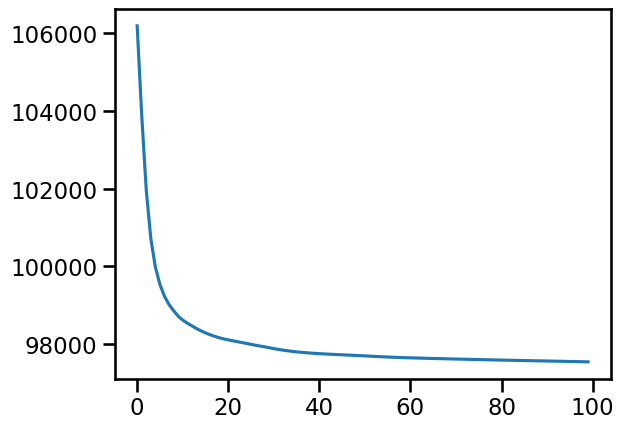

In [28]:
plt.plot(model.history['loss'])

In [35]:
model.calc_all_latent(target=[True, False, False, False, False])  # 这个target决定使用哪些omics及其都有的barcode用来inference

latent = model.get_all_latent()

In [37]:
if True:
    latent_barcode = np.array([_.split('~')[1] for _ in latent[1]])
    df_latent = pd.DataFrame(latent[0], index=latent_barcode)
    df_latent.to_csv('./outputs/MB_RNA+ATAC+Histone/res.csv')

else:
    df_latent = pd.read_csv('./outputs/MB_RNA+ATAC+Histone/res.csv', index_col=0)
    df_latent.index = df_latent.index.astype('str')

In [38]:
ad_mult_rna.obsm['X_emb'] = df_latent.loc[ad_mult_rna.obs_names, :].values
ad_mult_rna2.obsm['X_emb'] = df_latent.loc[ad_mult_rna2.obs_names, :].values
ad_mult_rna3.obsm['X_emb'] = df_latent.loc[ad_mult_rna3.obs_names, :].values
ad_mult_rna4.obsm['X_emb'] = df_latent.loc[ad_mult_rna4.obs_names, :].values

In [39]:
ad_mosaic = sc.concat([ad_mult_rna, ad_mult_rna2, ad_mult_rna3, ad_mult_rna4])
ad_mosaic = get_umap(ad_mosaic, ['X_emb'])

# try:
    
#     # from sklearn.cluster import KMeans
#     # print("mclust failed, try kmeans")
#     # kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['X_emb'])
#     # ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
#     # clust_key = 'kmeans'

#     ad_mosaic = mclust_R(ad_mosaic, 10, used_obsm='X_emb')  
#     clust_key = 'mclust'
    
# except:

#     from sklearn.cluster import KMeans
#     print("mclust failed, try kmeans")
#     kmeans = KMeans(n_clusters=10, random_state=0).fit(ad_mosaic.obsm['X_emb'])
#     ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
#     clust_key = 'kmeans'

#     # ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='X_emb')  
#     # clust_key = 'mclust'

# ad_mosaic.obs[clust_key] = ad_mosaic.obs[clust_key].astype('str')
# split_ob([ad_bridge_rna, ad_test_rna, ad_test_atac], ad_mosaic, ob='obs', key=clust_key)

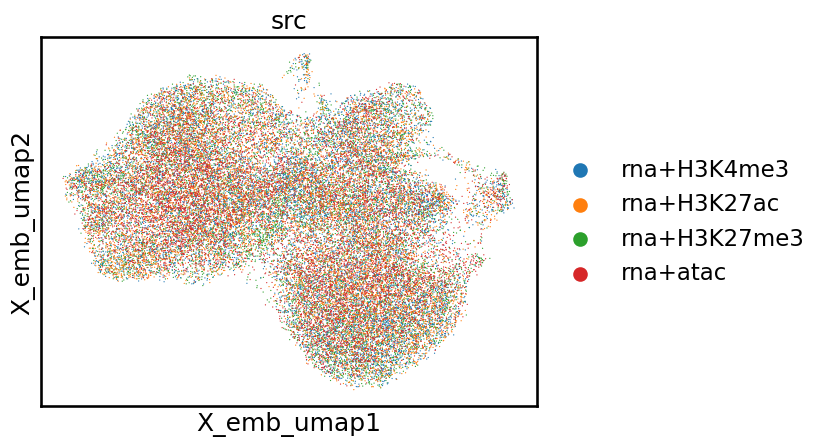

In [40]:
# # plot
wrap_warn_plot(ad_mosaic, 'X_emb_umap', ['src'])

In [44]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='X_emb', use_neighbors=False,
)
lisi_res['src_iLISI'][0]

0.7461288371353926

### batch corr

In [45]:
from batchCorr import HARMONY

ad_mosaic.obsm['X_emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['X_emb']), ad_mosaic.obs['src'].to_list())
ad_mosaic = get_umap(ad_mosaic, ['X_emb_har'])
# split_ob([ad_bridge_rna, ad_test1_rna, ad_test2_atac], ad_mosaic, ob='obsm', key='X_emb_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


In [47]:
# ad_mosaic.obs['after_clust'] = ad_mosaic.obs[clust_key].to_list()

In [48]:
# r1 = eval_ads([ad_mosaic, ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'Combined_Clusters_annotation', clust_key)
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='X_emb_har', use_neighbors=False,
)
r2 = lisi_res['src_iLISI'][0]

In [49]:
r2

0.7784204323178116

### Vis

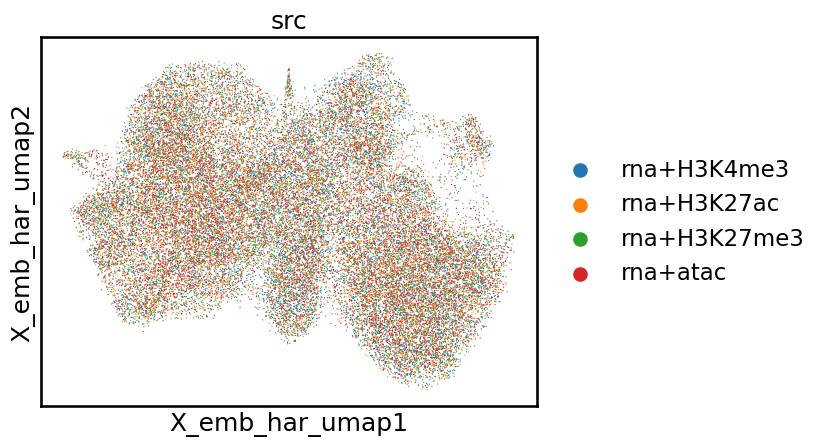

In [50]:
wrap_warn_plot(ad_mosaic, 'X_emb_har_umap', ['src'])

# unify type colors
# mclust_type2dict = dict(zip(ad_mosaic.obs.mclust.cat.categories, ad_mosaic.uns['mclust_colors']))
# label_type2dict = dict(zip(ad_mosaic.obs.Combined_Clusters_annotation.cat.categories, ad_mosaic.uns['Combined_Clusters_annotation_colors']))
# ad_bridge_rna, ad_test1_rna, ad_test2_atac = unify_colors(
#     [ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'mclust', mclust_type2dict)
# ad_bridge_rna, ad_test1_rna, ad_test2_atac = unify_colors(
#     [ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'Combined_Clusters_annotation', label_type2dict)

In [51]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/MB_RNA+ATAC+Histone/cobolt'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
# df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['X_emb_har'], index=ad_mosaic.obs_names)
# df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))